In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import sys
sys.path.append("../../../")
import numpy as np

In [3]:
#this would be a very lengthy calculation but could iterate over product of B gate family (in both gc and gg) with itself, find best combination of #k gates
from src.hamiltonian import ConversionGainHamiltonian
from src.utils.custom_gates import CustomCostGate
from src.basis import MixedOrderBasisCircuitTemplate
from src.utils.polytope_wrap import coverage_to_haar_expectation
from weylchamber import c1c2c3

In [6]:
#this shows combinining 2 conversion-gain gates to minimize expected haar cost
#what is probably more useful is to instead minimize cost on a circuit, so we can get better coverage ie a hard to build swap gate

h = ConversionGainHamiltonian()
SPEED_LIMIT = np.pi/2

#TODO rewrite this in a better way that saves progress on these lengthy calculation
#can I have polytopes precomputed and saved somewhere?

data = []
coord_data = []
cost_data = []
#for j in [0,2,4,6]: #iterate from iswap to B family
ratios = [(0, np.pi/2), (np.pi/4, np.pi/4), (np.pi/8, 3*np.pi/8), ((4/3)*np.pi/8, (4/3)*2*np.pi/8), (np.pi/8, 2*np.pi/8)]#(0, np.pi/2), (0, np.pi/2),]
#ratios = [(np.pi/8, 2*np.pi/8)]
#iswap, cnot, B, 
for r in ratios:
    temp_data = []
    temp_coord_data = []
    temp_cost_data = []
    #for i, c in enumerate(range(1,7,1)):
    for i, c in enumerate(range(0,1)):
        gc = r[0]*(1-c/10)
        gg = r[1]*(1-c/10)
        cost = sum([gc, gg])/SPEED_LIMIT
        u = h._construct_U_lambda(gc, gg)(1).full()
        gate1 = CustomCostGate(u, f"B({gc, gg})", cost=cost)

        basis_gates = [gate1]# ,gate3]  
        basis = MixedOrderBasisCircuitTemplate(base_gates=basis_gates, chatty_build=False)
        temp_data.append((i, coverage_to_haar_expectation(basis.coverage)))
        temp_coord_data.append(c1c2c3(gate1.to_matrix()))
        temp_cost_data.append((i, cost))

    data.append(temp_data)
    coord_data.append(temp_coord_data)
    cost_data.append(temp_cost_data)

INFO:root:==== Working to build a set of covering polytopes ====
INFO:root:==== Haar volumes ====


 deg 0	 | Sequence name
0.00000	 | 
0.00000	 | B((0.0, 1.5707963267948966))
0.00000	 | B((0.0, 1.5707963267948966)).B((0.0, 1.5707963267948966))
1.00000	 | B((0.0, 1.5707963267948966)).B((0.0, 1.5707963267948966)).B((0.0, 1.5707963267948966))


INFO:root:Haar-expectation cost: 3.000000000000001
INFO:root:==== Working to build a set of covering polytopes ====
INFO:root:==== Haar volumes ====


 deg 0	 | Sequence name
0.00000	 | 
0.00000	 | B((0.7853981633974483, 0.7853981633974483))
0.00000	 | B((0.7853981633974483, 0.7853981633974483)).B((0.7853981633974483, 0.7853981633974483))
1.00000	 | B((0.7853981633974483, 0.7853981633974483)).B((0.7853981633974483, 0.7853981633974483)).B((0.7853981633974483, 0.7853981633974483))


INFO:root:Haar-expectation cost: 3.000000000000001
INFO:root:==== Working to build a set of covering polytopes ====
INFO:root:==== Haar volumes ====


 deg 0	 | Sequence name
0.00000	 | 
0.00000	 | B((0.39269908169872414, 1.1780972450961724))
1.00000	 | B((0.39269908169872414, 1.1780972450961724)).B((0.39269908169872414, 1.1780972450961724))


INFO:root:Haar-expectation cost: 2.0
INFO:root:==== Working to build a set of covering polytopes ====
INFO:root:==== Haar volumes ====


 deg 0	 | Sequence name
0.00000	 | 
0.00000	 | B((0.5235987755982988, 1.0471975511965976))
0.99960	 | B((0.5235987755982988, 1.0471975511965976)).B((0.5235987755982988, 1.0471975511965976))
0.00040	 | B((0.5235987755982988, 1.0471975511965976)).B((0.5235987755982988, 1.0471975511965976)).B((0.5235987755982988, 1.0471975511965976))


INFO:root:Haar-expectation cost: 2.0003962493875393
INFO:root:==== Working to build a set of covering polytopes ====
INFO:root:==== Haar volumes ====


 deg 0	 | Sequence name
0.00000	 | 
0.00000	 | B((0.39269908169872414, 0.7853981633974483))
0.95827	 | B((0.39269908169872414, 0.7853981633974483)).B((0.39269908169872414, 0.7853981633974483))
0.04173	 | B((0.39269908169872414, 0.7853981633974483)).B((0.39269908169872414, 0.7853981633974483)).B((0.39269908169872414, 0.7853981633974483))


INFO:root:Haar-expectation cost: 1.5312968527381312


In [7]:
cost_data

[[(0, 1.0)], [(0, 1.0)], [(0, 1.0)], [(0, 1.0)], [(0, 0.75)]]

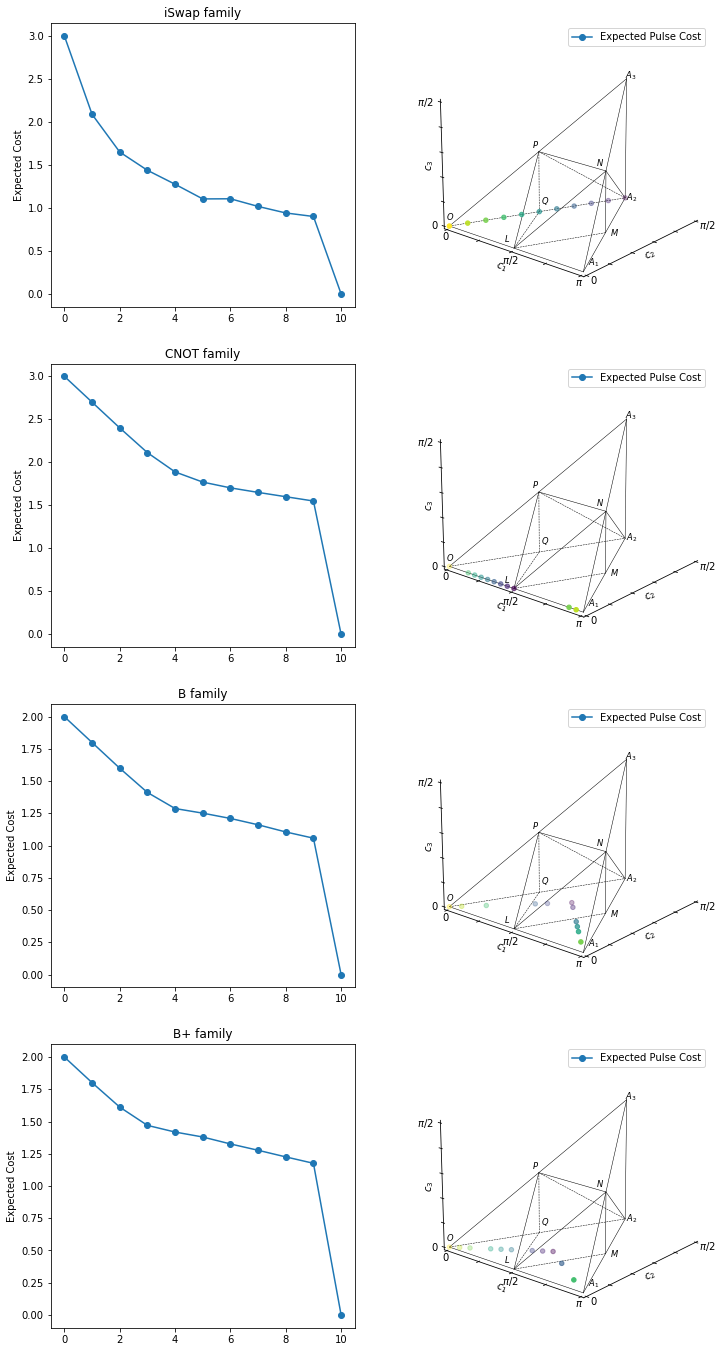

In [8]:
#TODO eventually move this to src.utils.visualize module once flushed out

import matplotlib.pyplot as plt
from src.utils.visualize import weyl_training_plot
plt.close()
fig = plt.figure(figsize=(12,6*len(data)))
for index, family_data in enumerate(zip(data,coord_data, cost_data)):
    axs = fig.add_subplot(len(data), 2, 2*index+1)
    l1,=axs.plot(*zip(*(family_data[0])), '-o', label='expect haar pulse cost')
    #axs.plot(*zip(*(np.array(family_data[2]))), '-o', label='drive power')
    #l2,=axs.plot(*zip(*[(i, d[0][1]/d[1][1]) for i, d in enumerate(zip(family_data[0], family_data[2]))]), '-o')
    axs.set_title(['iSwap', 'CNOT', 'B','B+'][index] + ' family')
    #axs.set_xlabel(f"gc = PI/(4+x)")
    axs.set_ylabel("Expected Cost")
    axs= fig.add_subplot(len(data),2,2*index+2, projection="3d")
    weyl_training_plot(axs, family_data[1])

    #axs.legend([l1,l2], ["Expected Pulse Cost", "Expected Gate Count"])
    axs.legend([l1], ["Expected Pulse Cost"])

Text(0.5, 0, 'Drive Power Cost')

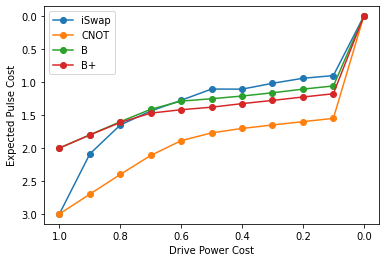

In [9]:
#replot all but with powers aligned
plt.close()
for index in range(len(data)):
    temp = []
    for x,y in zip(cost_data[index], data[index]):
        #print(x[1], y[1])
        temp.append((x[1],y[1]))
    plt.plot(*zip(*temp), label=['iSwap', 'CNOT', 'B', 'B+'][index], marker='o')
plt.legend()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.ylabel("Expected Pulse Cost")
plt.xlabel("Drive Power Cost")

In [ ]:
#TODO force B+ to use noninteger ratios for drive power cost
#TODO plot ratios with more data points, 

In [69]:
#this shows combinining 2 conversion-gain gates to minimize expected haar cost
#what is probably more useful is to instead minimize cost on a circuit, so we can get better coverage ie a hard to build swap gate

h = ConversionGainHamiltonian()
SPEED_LIMIT = np.pi/2
denom=16

#TODO rewrite this in a better way that saves progress on these lengthy calculation
#can I have polytopes precomputed and saved somewhere?

data = []
coord_data = []
cost_data = []
#for j in [0,2,4,6]: #iterate from iswap to B family
j_range = [0,2,4,6]
for j in j_range:
    temp_data = []
    temp_coord_data = []
    temp_cost_data = []
    for i in range(0,11,1):
        cost = sum([np.pi/(4+i), j*np.pi/denom])/SPEED_LIMIT
        u = h._construct_U_lambda(np.pi/(4+i), j*np.pi/denom)(1).full()
        gate1 = CustomCostGate(u, f"B({np.pi/(4+i), j*np.pi/denom})", cost=1)

        basis_gates = [gate1]# ,gate3]  
        basis = MixedOrderBasisCircuitTemplate(base_gates=basis_gates, chatty_build=False)
        temp_data.append((i, coverage_to_haar_expectation(basis.coverage)))
        temp_coord_data.append(c1c2c3(gate1.to_matrix()))
        temp_cost_data.append((i, cost))

    data.append(temp_data)
    coord_data.append(temp_coord_data)
    cost_data.append(temp_cost_data)

[[(0, 0.5),
  (1, 0.4),
  (2, 0.3333333333333333),
  (3, 0.2857142857142857),
  (4, 0.25),
  (5, 0.2222222222222222),
  (6, 0.2)],
 [(0, 0.75),
  (1, 0.65),
  (2, 0.5833333333333333),
  (3, 0.5357142857142857),
  (4, 0.5),
  (5, 0.47222222222222227),
  (6, 0.45)],
 [(0, 1.0),
  (1, 0.9),
  (2, 0.8333333333333333),
  (3, 0.7857142857142857),
  (4, 0.75),
  (5, 0.7222222222222222),
  (6, 0.7)],
 [(0, 1.25),
  (1, 1.15),
  (2, 1.0833333333333333),
  (3, 1.0357142857142858),
  (4, 1.0),
  (5, 0.9722222222222222),
  (6, 0.95)]]

In [11]:
#this shows combinining 2 conversion-gain gates to minimize expected haar cost
#what is probably more useful is to instead minimize cost on a circuit, so we can get better coverage ie a hard to build swap gate

h = ConversionGainHamiltonian()
SPEED_LIMIT = np.pi/2
denom=16

#TODO rewrite this in a better way that saves progress on these lengthy calculation
#can I have polytopes precomputed and saved somewhere?

data = []
coord_data = []
cost_data = []
#for j in [0,2,4,6]: #iterate from iswap to B family
j_range = [0,2,4,6]
for j in j_range:
    temp_data = []
    temp_coord_data = []
    temp_cost_data = []

    desired_power_range = [1.5, 1, .5] #[2/el for el in range(4,11)]

    for power_target in desired_power_range:
        #cost = sum([np.pi/(4+i), j*np.pi/denom])/SPEED_LIMIT
        try:
            i = np.pi/(SPEED_LIMIT * power_target - (j*np.pi/denom)) - 4
            if i < 0:
                raise ValueError()
            u = h._construct_U_lambda(np.pi/(4+i), j*np.pi/denom)(1).full()
            cost = sum([np.pi/(4+i), j*np.pi/denom])/SPEED_LIMIT
            gate1 = CustomCostGate(u, f"B({np.pi/(4+i), j*np.pi/denom})", cost=cost)

            basis_gates = [gate1]# ,gate3]  
            basis = MixedOrderBasisCircuitTemplate(base_gates=basis_gates, chatty_build=False)
            temp_data.append((i, coverage_to_haar_expectation(basis.coverage)))
            temp_coord_data.append(c1c2c3(gate1.to_matrix()))
            temp_cost_data.append((i, cost))
        except Exception:
            print(f"failed j:{j}, power_targer:{power_target}")
            #temp_data.append((i, -1))
            #temp_coord_data.append(c1c2c3(gate1.to_matrix()))
            #temp_cost_data.append((i, cost))

    data.append(temp_data)
    coord_data.append(temp_coord_data)
    cost_data.append(temp_cost_data)

failed j:0, power_targer:1.5
failed j:0, power_targer:1


INFO:root:==== Working to build a set of covering polytopes ====
INFO:root:==== Haar volumes ====


 deg 0	 | Sequence name
0.00000	 | 
0.00000	 | B((0.7853981633974483, 0.0))
0.79012	 | B((0.7853981633974483, 0.0)).B((0.7853981633974483, 0.0))
0.20988	 | B((0.7853981633974483, 0.0)).B((0.7853981633974483, 0.0)).B((0.7853981633974483, 0.0))


INFO:root:Haar-expectation cost: 1.1049413181578387


failed j:2, power_targer:1.5
failed j:2, power_targer:1


INFO:root:==== Working to build a set of covering polytopes ====
INFO:root:==== Haar volumes ====


 deg 0	 | Sequence name
0.00000	 | 
0.00000	 | B((0.39269908169872414, 0.39269908169872414))
0.00000	 | B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 0.39269908169872414))
0.50000	 | B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 0.39269908169872414))
0.45988	 | B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 0.39269908169872414))
0.03998	 | B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 0.39269908169872414))
0.00014	 | B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 

INFO:root:Haar-expectation cost: 1.7701274104040134


failed j:4, power_targer:1.5


INFO:root:==== Working to build a set of covering polytopes ====
INFO:root:==== Haar volumes ====


 deg 0	 | Sequence name
0.00000	 | 
0.00000	 | B((0.7853981633974483, 0.7853981633974483))
0.00000	 | B((0.7853981633974483, 0.7853981633974483)).B((0.7853981633974483, 0.7853981633974483))
1.00000	 | B((0.7853981633974483, 0.7853981633974483)).B((0.7853981633974483, 0.7853981633974483)).B((0.7853981633974483, 0.7853981633974483))


INFO:root:Haar-expectation cost: 3.000000000000001


failed j:4, power_targer:0.5
failed j:6, power_targer:1.5


INFO:root:==== Working to build a set of covering polytopes ====
INFO:root:==== Haar volumes ====


 deg 0	 | Sequence name
0.00000	 | 
0.00000	 | B((0.39269908169872414, 1.1780972450961724))
1.00000	 | B((0.39269908169872414, 1.1780972450961724)).B((0.39269908169872414, 1.1780972450961724))


INFO:root:Haar-expectation cost: 2.0


failed j:6, power_targer:0.5


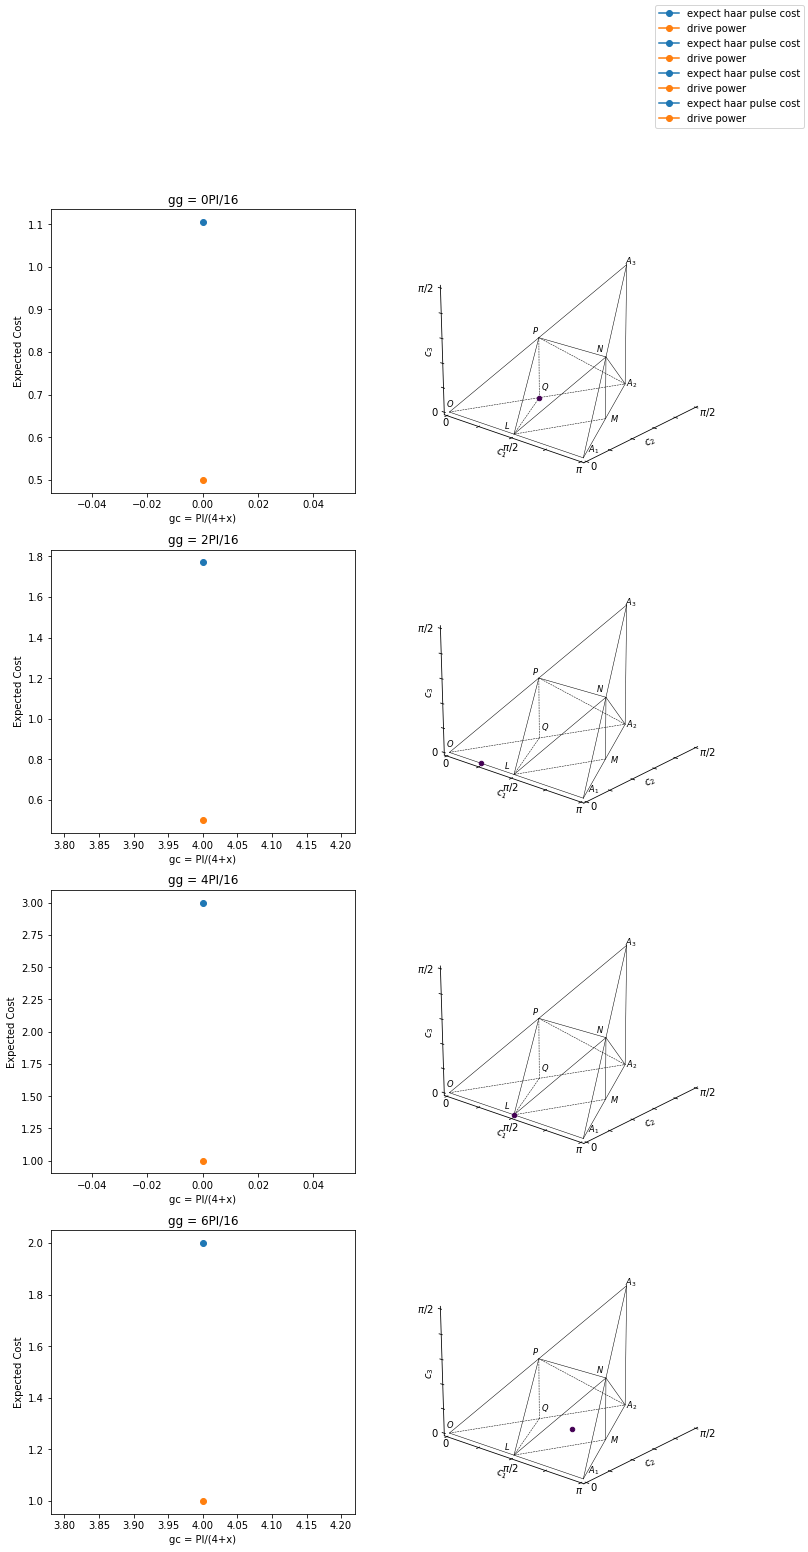

In [12]:
#TODO eventually move this to src.utils.visualize module once flushed out

import matplotlib.pyplot as plt
from src.utils.visualize import weyl_training_plot
plt.close()
fig = plt.figure(figsize=(12,6*len(data)))
for index, family_data in enumerate(zip(data,coord_data, cost_data)):
    axs = fig.add_subplot(len(data), 2, 2*index+1)
    axs.plot(*zip(*(family_data[0])), '-o', label='expect haar pulse cost')
    axs.plot(*zip(*(family_data[2])), '-o', label='drive power')
    axs.set_title(f'gg = {j_range[index]}PI/{denom}')
    axs.set_xlabel(f"gc = PI/(4+x)")
    axs.set_ylabel("Expected Cost")
    axs= fig.add_subplot(len(data),2,2*index+2, projection="3d")
    weyl_training_plot(axs, family_data[1])

fig.legend()

In [1]:
#replot all but with powers aligned
plt.close()
for index in range(len(data)):
    temp = []
    for x,y in zip(cost_data[index], data[index]):
        #print(x[1], y[1])
        temp.append((x[1],y[1]))
    plt.plot(*zip(*temp), label=['iswap', 'b++', 'b+', 'b'][index])
plt.legend()
plt.ylabel("Expected Pulse Cost")
plt.xlabel("Drive Power Cost")

NameError: name 'plt' is not defined

In [6]:
#this shows combinining 2 conversion-gain gates to minimize expected haar cost
#what is probably more useful is to instead minimize cost on a circuit, so we can get better coverage ie a hard to build swap gate

h = ConversionGainHamiltonian()
SPEED_LIMIT = np.pi/2
denom=16

#TODO rewrite this in a better way that saves progress on these lengthy calculation
#can I have polytopes precomputed and saved somewhere?

data = []
coord_data = []
cost_data = []
#for j in [0,2,4,6]: #iterate from iswap to B family
j_range = [2]
for j in j_range:
    temp_data = []
    temp_coord_data = []
    temp_cost_data = []
    for i in range(0,6,1):
        cost = sum([np.pi/(4+i), j*np.pi/denom])/SPEED_LIMIT
        u = h._construct_U_lambda(np.pi/(4+i), j*np.pi/denom)(1).full()
        gate1 = CustomCostGate(u, f"B({np.pi/(4+i), j*np.pi/denom})", cost=cost)

        basis_gates = [gate1]# ,gate3]  
        basis = MixedOrderBasisCircuitTemplate(base_gates=basis_gates, chatty_build=False)
        temp_data.append((i, coverage_to_haar_expectation(basis.coverage)))
        temp_coord_data.append(c1c2c3(gate1.to_matrix()))
        temp_cost_data.append((i, cost))

    data.append(temp_data)
    coord_data.append(temp_coord_data)
    cost_data.append(temp_cost_data)

INFO:root:==== Working to build a set of covering polytopes ====
INFO:root:==== Haar volumes ====


 deg 0	 | Sequence name
0.00000	 | 
0.00000	 | B((0.7853981633974483, 0.39269908169872414))
0.95827	 | B((0.7853981633974483, 0.39269908169872414)).B((0.7853981633974483, 0.39269908169872414))
0.04173	 | B((0.7853981633974483, 0.39269908169872414)).B((0.7853981633974483, 0.39269908169872414)).B((0.7853981633974483, 0.39269908169872414))


INFO:root:Haar-expectation cost: 1.5312968527381312
INFO:root:==== Working to build a set of covering polytopes ====
INFO:root:==== Haar volumes ====


 deg 0	 | Sequence name
0.00000	 | 
0.00000	 | B((0.6283185307179586, 0.39269908169872414))
0.62183	 | B((0.6283185307179586, 0.39269908169872414)).B((0.6283185307179586, 0.39269908169872414))
0.37752	 | B((0.6283185307179586, 0.39269908169872414)).B((0.6283185307179586, 0.39269908169872414)).B((0.6283185307179586, 0.39269908169872414))
0.00065	 | B((0.6283185307179586, 0.39269908169872414)).B((0.6283185307179586, 0.39269908169872414)).B((0.6283185307179586, 0.39269908169872414)).B((0.6283185307179586, 0.39269908169872414))


INFO:root:Haar-expectation cost: 1.5462369590085763
INFO:root:==== Working to build a set of covering polytopes ====
INFO:root:==== Haar volumes ====


 deg 0	 | Sequence name
0.00000	 | 
0.00000	 | B((0.5235987755982988, 0.39269908169872414))
0.24664	 | B((0.5235987755982988, 0.39269908169872414)).B((0.5235987755982988, 0.39269908169872414))
0.71325	 | B((0.5235987755982988, 0.39269908169872414)).B((0.5235987755982988, 0.39269908169872414)).B((0.5235987755982988, 0.39269908169872414))
0.04011	 | B((0.5235987755982988, 0.39269908169872414)).B((0.5235987755982988, 0.39269908169872414)).B((0.5235987755982988, 0.39269908169872414)).B((0.5235987755982988, 0.39269908169872414))
0.00000	 | B((0.5235987755982988, 0.39269908169872414)).B((0.5235987755982988, 0.39269908169872414)).B((0.5235987755982988, 0.39269908169872414)).B((0.5235987755982988, 0.39269908169872414)).B((0.5235987755982988, 0.39269908169872414))


INFO:root:Haar-expectation cost: 1.6295331216768953
INFO:root:==== Working to build a set of covering polytopes ====
INFO:root:==== Haar volumes ====


 deg 0	 | Sequence name
0.00000	 | 
0.00000	 | B((0.4487989505128276, 0.39269908169872414))
0.06320	 | B((0.4487989505128276, 0.39269908169872414)).B((0.4487989505128276, 0.39269908169872414))
0.71034	 | B((0.4487989505128276, 0.39269908169872414)).B((0.4487989505128276, 0.39269908169872414)).B((0.4487989505128276, 0.39269908169872414))
0.22365	 | B((0.4487989505128276, 0.39269908169872414)).B((0.4487989505128276, 0.39269908169872414)).B((0.4487989505128276, 0.39269908169872414)).B((0.4487989505128276, 0.39269908169872414))
0.00281	 | B((0.4487989505128276, 0.39269908169872414)).B((0.4487989505128276, 0.39269908169872414)).B((0.4487989505128276, 0.39269908169872414)).B((0.4487989505128276, 0.39269908169872414)).B((0.4487989505128276, 0.39269908169872414))
0.00000	 | B((0.4487989505128276, 0.39269908169872414)).B((0.4487989505128276, 0.39269908169872414)).B((0.4487989505128276, 0.39269908169872414)).B((0.4487989505128276, 0.39269908169872414)).B((0.4487989505128276, 0.39269908169872414)

INFO:root:Haar-expectation cost: 1.6961039355387122
INFO:root:==== Working to build a set of covering polytopes ====
INFO:root:==== Haar volumes ====


 deg 0	 | Sequence name
0.00000	 | 
0.00000	 | B((0.39269908169872414, 0.39269908169872414))
0.00000	 | B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 0.39269908169872414))
0.50000	 | B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 0.39269908169872414))
0.45988	 | B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 0.39269908169872414))
0.03998	 | B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 0.39269908169872414))
0.00014	 | B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 0.39269908169872414)).B((0.39269908169872414, 

INFO:root:Haar-expectation cost: 1.7701274104040134
INFO:root:==== Working to build a set of covering polytopes ====
INFO:root:==== Haar volumes ====


 deg 0	 | Sequence name
0.00000	 | 
0.00000	 | B((0.3490658503988659, 0.39269908169872414))
0.02243	 | B((0.3490658503988659, 0.39269908169872414)).B((0.3490658503988659, 0.39269908169872414))
0.47757	 | B((0.3490658503988659, 0.39269908169872414)).B((0.3490658503988659, 0.39269908169872414)).B((0.3490658503988659, 0.39269908169872414))
0.45988	 | B((0.3490658503988659, 0.39269908169872414)).B((0.3490658503988659, 0.39269908169872414)).B((0.3490658503988659, 0.39269908169872414)).B((0.3490658503988659, 0.39269908169872414))
0.03998	 | B((0.3490658503988659, 0.39269908169872414)).B((0.3490658503988659, 0.39269908169872414)).B((0.3490658503988659, 0.39269908169872414)).B((0.3490658503988659, 0.39269908169872414)).B((0.3490658503988659, 0.39269908169872414))
0.00014	 | B((0.3490658503988659, 0.39269908169872414)).B((0.3490658503988659, 0.39269908169872414)).B((0.3490658503988659, 0.39269908169872414)).B((0.3490658503988659, 0.39269908169872414)).B((0.3490658503988659, 0.39269908169872414)

INFO:root:Haar-expectation cost: 1.6611958912893174


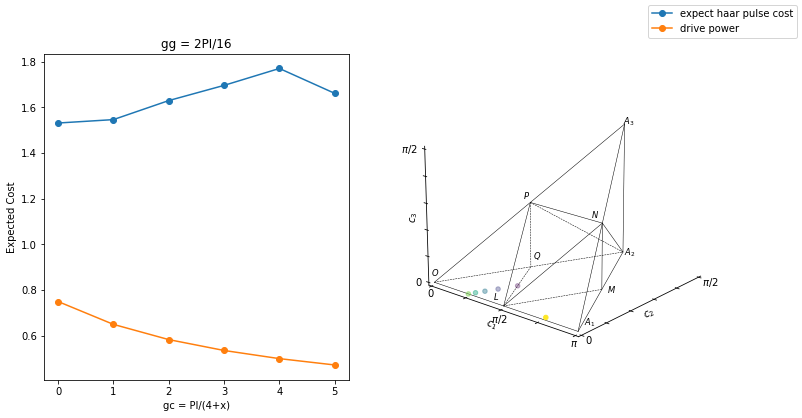

In [7]:
#TODO eventually move this to src.utils.visualize module once flushed out

import matplotlib.pyplot as plt
from src.utils.visualize import weyl_training_plot
plt.close()
fig = plt.figure(figsize=(12,6*len(data)))
for index, family_data in enumerate(zip(data,coord_data, cost_data)):
    axs = fig.add_subplot(len(data), 2, 2*index+1)
    axs.plot(*zip(*(family_data[0])), '-o', label='expect haar pulse cost')
    axs.plot(*zip(*(family_data[2])), '-o', label='drive power')
    axs.set_title(f'gg = {j_range[index]}PI/{denom}')
    axs.set_xlabel(f"gc = PI/(4+x)")
    axs.set_ylabel("Expected Cost")
    axs= fig.add_subplot(len(data),2,2*index+2, projection="3d")
    weyl_training_plot(axs, family_data[1])

fig.legend()